In [1]:
using Revise

includet("./modules/RidgeRegression.jl")
includet("./modules/Experiments.jl")
includet("./modules/Replica.jl")

using .RidgeRegression: solve_rr
using .Experiments: generate_data, convert_to_vec, calc_generalization_error, calc_orderparams
using .Replica: solve_replica
using Distributions, Random, Statistics, CairoMakie, LinearAlgebra

In [2]:
τ = 1.2
κ = 3.0
σ = 0.9
λ = 0.1
α = 4.0
α_tilde_theory = α * range(0.1, 4.0, length=100)
ρ = 0.5
σ_test = 0.0;

In [3]:
error_memorys_theory = zeros(length(α_tilde_theory))
error_inds_theory = zeros(length(α_tilde_theory))
error_oods_theory = zeros(length(α_tilde_theory))
for (i, α_tilde) in enumerate(α_tilde_theory)
    q, m, χ, q_bar, χ_bar, q̂, m̂, χ̂, q̂_bar, χ̂_bar, m_bar, q0, m0 = solve_replica(α, τ, κ, λ, σ, ρ)

    error_memorys_theory[i] = 1 - 2m + q + q_bar / α_tilde
    error_inds_theory[i] = 1 - 2m0 + q0 + q_bar / α_tilde
    error_oods_theory[i] = 1 - 2m_bar + q_bar + q_bar / α_tilde
end


In [4]:
D = 60
L = round(Int, D * α)

M = round(Int, D^2 * τ)
M0 = round(Int, D * κ)
n_trials = 5 # trials for learning data
#α_tilde_sims = α * [0.15, 0.4, 0.5, 0.75, 1.0]
α_tilde_sims = α * [0.4, 0.5, 1.0, 2.0, 3.0, 3.5]

gen_errors_memorys_sims = zeros(length(α_tilde_sims), n_trials)
gen_errors_oods_sims = zeros(length(α_tilde_sims), n_trials)
gen_errors_inds_sims = zeros(length(α_tilde_sims), n_trials)



Threads.@threads for ((i, α_tilde), j) in collect(Iterators.product(enumerate(α_tilde_sims), 1:n_trials))

    L_tilde = round(Int, D * α_tilde)

    r = round(Int, D * ρ)
    rng_learn = MersenneTwister(122 + 20i + j)

    # generate pretraining data
    X, W0, W, Y, H, A = generate_data(D, L, M, M0, σ, r; rng=rng_learn)
    vecH = convert_to_vec(H)

    # solve ridge regression
    vec_Γ = solve_rr(vecH, Y[:, end], bias=false, lambda = λ * M0, mean_loss=false)

    # calc generalization error
    n_test = 3 # trials for tasks
    n_samples_per_task = 3 # trials for data x, y
    rng_test = MersenneTwister(324 + 21i + 2j)
    gen_errors_memorys_sims[i, j] = calc_generalization_error(W0, vec_Γ, A, L_tilde, r, σ_test; n_test=n_test, n_samples_per_task=n_samples_per_task, rng=rng_test, error_type =:memory)
    gen_errors_oods_sims[i, j] = calc_generalization_error(W0, vec_Γ, A, L_tilde, r, σ_test; n_test=n_test, n_samples_per_task=n_samples_per_task, rng=rng_test, error_type =:ood)
    gen_errors_inds_sims[i, j] = calc_generalization_error(W0, vec_Γ, A, L_tilde, r, σ_test; n_test=n_test, n_samples_per_task=n_samples_per_task, rng=rng_test, error_type =:id)

end

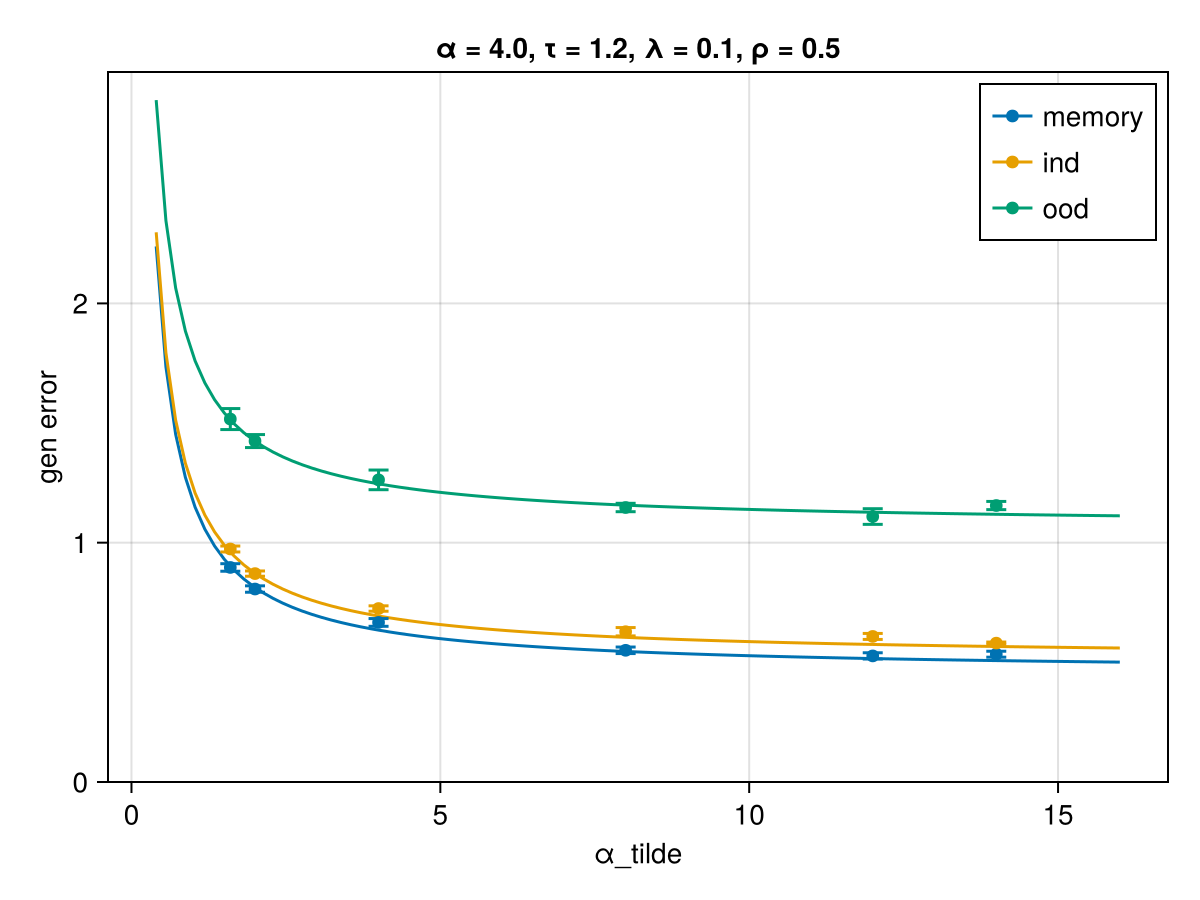

CairoMakie.Screen{IMAGE}


In [5]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="α_tilde", ylabel="gen error", title="α = $α, τ = $τ, λ = $λ, ρ = $ρ", limits=(nothing, nothing, 0.0, nothing))   
lines!(ax, α_tilde_theory, error_memorys_theory, label="memory")
lines!(ax, α_tilde_theory, error_inds_theory, label="ind")
lines!(ax, α_tilde_theory, error_oods_theory, label="ood")
scatter!(ax, α_tilde_sims, vec(mean(gen_errors_memorys_sims, dims=2)), label="memory")
scatter!(ax, α_tilde_sims, vec(mean(gen_errors_inds_sims, dims=2)), label="ind")
scatter!(ax, α_tilde_sims, vec(mean(gen_errors_oods_sims, dims=2)), label="ood")
errorbars!(ax, α_tilde_sims, vec(mean(gen_errors_memorys_sims, dims=2)), vec(std(gen_errors_memorys_sims, dims=2) ./ sqrt(n_trials)), whiskerwidth=10)
errorbars!(ax, α_tilde_sims, vec(mean(gen_errors_inds_sims, dims=2)), vec(std(gen_errors_inds_sims, dims=2) ./ sqrt(n_trials)), whiskerwidth=10)
errorbars!(ax, α_tilde_sims, vec(mean(gen_errors_oods_sims, dims=2)), vec(std(gen_errors_oods_sims, dims=2) ./ sqrt(n_trials)), whiskerwidth=10)
axislegend(ax, merge=true)
display(fig)